# Paradigm 07: Cascading Knowledge Cache Research Agent

This notebook implements the **Cascading Knowledge Cache (CKC)** paradigm.

## Core Concept

The CKC architecture introduces an intelligent intermediary layer between search intent and search execution. Rather than treating each search as isolated, accumulated results become a growing internal knowledge base consulted before incurring the cost of external retrieval.

**Fundamental Principle**: Never fetch what you already know, and use what you know to fetch smarter.

## Key Principles

1. **Fail Fast, Fail Cheap**: Cheapest operations execute first
2. **Graduated Confidence**: HIGH/MEDIUM/LOW classifications
3. **Specificity Awareness**: Query precision modulates thresholds
4. **Temporal Intelligence**: Detect time-sensitive queries

## Architecture

- **Layer 1**: Deterministic Deduplication (exact matching)
- **Layer 2**: Semantic Similarity Retrieval (vector search + confidence)
- **Layer 3**: LLM-Augmented Judgment (gap analysis, query refinement)

## Technology Stack

- **LLM**: gpt-5-mini-2025-08-07
- **Web Search**: Tavily API
- **Embeddings**: OpenAI text-embedding-3-small
- **Tracing**: LangSmith
- **Framework**: LangGraph

## 1. Setup and Configuration

In [3]:
import os
import operator
import asyncio
import hashlib
import re
import json
from pathlib import Path
from typing import List, Dict, Tuple, Annotated, TypedDict, Literal, Optional, Any
from urllib.parse import urlparse
from dataclasses import dataclass, field
from datetime import datetime

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from tavily import TavilyClient

from langgraph.graph import StateGraph, START, END

import numpy as np

# Load environment variables
env_path = Path("../.env")
load_dotenv(env_path)

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

Environment configured successfully


In [4]:
# Initialize LLM, Tavily, and Embeddings
MODEL_NAME = "gpt-5-mini-2025-08-07"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0, max_retries=10)
tavily_client = TavilyClient()
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Cache Configuration
CHUNK_SIZE = 500  # characters
CHUNK_OVERLAP = 100  # characters
HIGH_CONFIDENCE_THRESHOLD = 0.75
LOW_CONFIDENCE_THRESHOLD = 0.45
SPECIFICITY_ADJUSTMENT_FACTOR = 0.2  # How much specificity raises thresholds
TOP_K_RETRIEVAL = 5

print(f"Using model: {MODEL_NAME}")
print(f"Embedding model: text-embedding-3-small")
print(f"Confidence thresholds: HIGH >= {HIGH_CONFIDENCE_THRESHOLD}, LOW < {LOW_CONFIDENCE_THRESHOLD}")

Using model: gpt-5-mini-2025-08-07
Embedding model: text-embedding-3-small
Confidence thresholds: HIGH >= 0.75, LOW < 0.45


## 2. Data Models

In [5]:
class CachedDocument(BaseModel):
    """A cached web document."""
    url: str = Field(description="Original URL")
    normalized_url: str = Field(description="Normalized URL for lookup")
    content: str = Field(description="Full text content")
    content_hash: str = Field(description="SHA-256 hash of content")
    title: str = Field(default="", description="Page title")
    retrieval_timestamp: str = Field(description="When this was retrieved")
    source_query: str = Field(default="", description="Query that led to this content")


class CachedChunk(BaseModel):
    """A chunk of content with embedding."""
    chunk_id: str = Field(description="Unique identifier")
    text: str = Field(description="Chunk text content")
    embedding: List[float] = Field(description="Vector embedding")
    source_url: str = Field(description="Source document URL")
    position: int = Field(description="Position within source document")


class QueryCacheEntry(BaseModel):
    """A cached query and its results."""
    original_query: str
    light_normalized: str
    aggressive_normalized: str
    timestamp: str
    result_urls: List[str]
    result_summary: str


class CacheDecision(BaseModel):
    """Record of a cache decision for observability."""
    query: str
    layer_reached: Literal["L1", "L2", "L3"]
    decision: Literal["HIT", "HIGH_CONF", "MEDIUM_CONF", "LOW_CONF",
                      "SUFFICIENT", "PARTIAL", "INSUFFICIENT"]
    confidence_score: float = 0.0
    action_taken: Literal["USE_CACHE", "SEARCH", "TARGETED_SEARCH"]
    reasoning: str = ""
    timestamp: str = ""

In [6]:
class QueryAnalysis(BaseModel):
    """Analysis of a query's characteristics."""
    original_query: str
    specificity_score: float = Field(description="0.0 (general) to 1.0 (very specific)")
    temporal_intent_score: float = Field(description="0.0 (no temporal) to 1.0 (time-sensitive)")
    adjusted_high_threshold: float
    adjusted_low_threshold: float
    extracted_entities: List[str] = Field(default_factory=list)
    extracted_dates: List[str] = Field(default_factory=list)

## 3. Knowledge Base Implementation

In [7]:
class KnowledgeBase:
    """Session-scoped knowledge base with cascading cache capabilities."""

    def __init__(self):
        self.url_registry: Dict[str, CachedDocument] = {}
        self.query_cache: Dict[str, QueryCacheEntry] = {}
        self.chunks: List[CachedChunk] = []
        self.chunk_embeddings: Optional[np.ndarray] = None  # For fast similarity

        # Statistics
        self.stats = {
            "total_queries": 0,
            "l1_hits": 0,
            "l2_high": 0,
            "l2_medium": 0,
            "l2_low": 0,
            "l3_sufficient": 0,
            "l3_partial": 0,
            "l3_insufficient": 0,
            "web_searches_executed": 0,
            "web_searches_avoided": 0
        }

    # === URL Normalization ===
    def normalize_url(self, url: str) -> str:
        """Normalize URL for consistent lookup."""
        try:
            parsed = urlparse(url)
            # Lowercase host, remove www prefix
            host = parsed.netloc.lower()
            if host.startswith("www."):
                host = host[4:]
            # Remove trailing slash from path
            path = parsed.path.rstrip("/")
            # Sort query parameters
            query_params = sorted(parsed.query.split("&")) if parsed.query else []
            # Remove tracking params
            tracking_params = {"utm_source", "utm_medium", "utm_campaign", "ref", "fbclid"}
            query_params = [p for p in query_params if p.split("=")[0] not in tracking_params]
            query = "&".join(query_params)
            # Reconstruct
            normalized = f"https://{host}{path}"
            if query:
                normalized += f"?{query}"
            return normalized
        except:
            return url.lower()

    # === Query Normalization ===
    def normalize_query_light(self, query: str) -> str:
        """Light normalization: lowercase, collapse whitespace."""
        return " ".join(query.lower().split())

    def normalize_query_aggressive(self, query: str) -> str:
        """Aggressive normalization: remove stop words, sort terms."""
        stop_words = {"the", "a", "an", "is", "are", "of", "in", "to", "for", "and", "or", "what", "how", "why", "when", "where"}
        light = self.normalize_query_light(query)
        terms = [t for t in light.split() if t not in stop_words and len(t) > 1]
        return " ".join(sorted(terms))

    # === Content Hashing ===
    def compute_content_hash(self, content: str) -> str:
        """Compute SHA-256 hash of content."""
        return hashlib.sha256(content.encode()).hexdigest()

    # === Document Storage ===
    def add_document(self, url: str, content: str, title: str = "", source_query: str = ""):
        """Add a document to the knowledge base."""
        normalized_url = self.normalize_url(url)

        doc = CachedDocument(
            url=url,
            normalized_url=normalized_url,
            content=content,
            content_hash=self.compute_content_hash(content),
            title=title,
            retrieval_timestamp=datetime.now().isoformat(),
            source_query=source_query
        )

        self.url_registry[normalized_url] = doc

        # Chunk and embed the content
        self._chunk_and_embed(doc)

        return doc

    def _chunk_and_embed(self, doc: CachedDocument):
        """Chunk document and compute embeddings."""
        content = doc.content
        chunks_text = []

        # Simple chunking with overlap
        for i in range(0, len(content), CHUNK_SIZE - CHUNK_OVERLAP):
            chunk_text = content[i:i + CHUNK_SIZE]
            if len(chunk_text) > 50:  # Minimum chunk size
                chunks_text.append(chunk_text)

        if not chunks_text:
            return

        # Compute embeddings (batch)
        embeddings = embeddings_model.embed_documents(chunks_text)

        # Create chunk objects
        for i, (text, embedding) in enumerate(zip(chunks_text, embeddings)):
            chunk = CachedChunk(
                chunk_id=f"{doc.content_hash[:8]}_{i}",
                text=text,
                embedding=embedding,
                source_url=doc.url,
                position=i
            )
            self.chunks.append(chunk)

        # Update embedding matrix for fast similarity
        self._update_embedding_matrix()

    def _update_embedding_matrix(self):
        """Update the numpy matrix of embeddings for fast search."""
        if self.chunks:
            self.chunk_embeddings = np.array([c.embedding for c in self.chunks])

    # === Query Cache ===
    def add_query(self, query: str, result_urls: List[str], result_summary: str):
        """Add a query to the cache."""
        entry = QueryCacheEntry(
            original_query=query,
            light_normalized=self.normalize_query_light(query),
            aggressive_normalized=self.normalize_query_aggressive(query),
            timestamp=datetime.now().isoformat(),
            result_urls=result_urls,
            result_summary=result_summary
        )

        # Store under both normalizations
        self.query_cache[entry.light_normalized] = entry
        self.query_cache[entry.aggressive_normalized] = entry

        return entry

    # === Lookups ===
    def lookup_url(self, url: str) -> Optional[CachedDocument]:
        """Check if URL is already cached."""
        normalized = self.normalize_url(url)
        return self.url_registry.get(normalized)

    def lookup_query_exact(self, query: str) -> Optional[QueryCacheEntry]:
        """Check for exact query match (light normalization)."""
        light = self.normalize_query_light(query)
        return self.query_cache.get(light)

    def lookup_query_aggressive(self, query: str) -> Optional[QueryCacheEntry]:
        """Check for bag-of-words query match (aggressive normalization)."""
        aggressive = self.normalize_query_aggressive(query)
        return self.query_cache.get(aggressive)

    # === Semantic Search ===
    def semantic_search(self, query: str, top_k: int = TOP_K_RETRIEVAL) -> List[Tuple[CachedChunk, float]]:
        """Find semantically similar chunks."""
        if not self.chunks or self.chunk_embeddings is None:
            return []

        # Embed query
        query_embedding = np.array(embeddings_model.embed_query(query))

        # Cosine similarity
        similarities = np.dot(self.chunk_embeddings, query_embedding) / (
            np.linalg.norm(self.chunk_embeddings, axis=1) * np.linalg.norm(query_embedding) + 1e-8
        )

        # Get top-k indices
        top_indices = np.argsort(similarities)[-top_k:][::-1]

        results = []
        for idx in top_indices:
            results.append((self.chunks[idx], float(similarities[idx])))

        return results

    def get_stats_summary(self) -> str:
        """Get human-readable stats summary."""
        total = self.stats["total_queries"]
        if total == 0:
            return "No queries processed yet."

        avoided = self.stats["web_searches_avoided"]
        executed = self.stats["web_searches_executed"]
        hit_rate = avoided / total * 100 if total > 0 else 0

        return f"""
Cache Statistics:
- Total queries: {total}
- Web searches avoided: {avoided} ({hit_rate:.1f}% hit rate)
- Web searches executed: {executed}
- Layer 1 hits: {self.stats['l1_hits']}
- Layer 2 HIGH confidence: {self.stats['l2_high']}
- Layer 2 MEDIUM confidence: {self.stats['l2_medium']}
- Layer 2 LOW confidence: {self.stats['l2_low']}
- Layer 3 SUFFICIENT: {self.stats['l3_sufficient']}
- Layer 3 PARTIAL: {self.stats['l3_partial']}
- Layer 3 INSUFFICIENT: {self.stats['l3_insufficient']}
- Documents cached: {len(self.url_registry)}
- Chunks indexed: {len(self.chunks)}
"""


# Initialize global knowledge base (session-scoped)
knowledge_base = KnowledgeBase()
print("Knowledge base initialized")

Knowledge base initialized


## 4. Query Analysis Functions

In [8]:
def compute_specificity(query: str) -> float:
    """Compute query specificity score (0.0 to 1.0)."""
    score = 0.0

    # Numerical precision: dates, percentages, specific numbers
    if re.search(r'\b\d{4}\b', query):  # Years
        score += 0.2
    if re.search(r'\d+%|\$\d+|\d+\s*(billion|million|thousand)', query, re.IGNORECASE):
        score += 0.2
    if re.search(r'Q[1-4]\s*\d{4}|FY\d{4}', query, re.IGNORECASE):  # Quarters, fiscal years
        score += 0.2

    # Proper nouns (capitalized words not at sentence start)
    proper_nouns = re.findall(r'(?<!^)(?<!\. )[A-Z][a-z]+', query)
    if len(proper_nouns) > 1:
        score += 0.15

    # Quoted phrases
    if '"' in query or "'" in query:
        score += 0.15

    # Specific question words
    if re.search(r'\b(exact|precise|specific|exactly|how many|what is the)\b', query, re.IGNORECASE):
        score += 0.1

    return min(score, 1.0)


def compute_temporal_intent(query: str) -> float:
    """Compute temporal intent score (0.0 to 1.0)."""
    score = 0.0

    # Explicit currency terms
    if re.search(r'\b(current|latest|now|today|recent|present|this week|this month|this year)\b', query, re.IGNORECASE):
        score += 0.4

    # Role/status queries
    if re.search(r'\b(who is the|what is the current|is .+ still)\b', query, re.IGNORECASE):
        score += 0.3

    # Comparative present
    if re.search(r'\b(how has .+ changed|compared to|versus last)\b', query, re.IGNORECASE):
        score += 0.2

    # Event-driven topics
    if re.search(r'\b(stock price|election|weather|score|breaking)\b', query, re.IGNORECASE):
        score += 0.3

    return min(score, 1.0)


def analyze_query(query: str) -> QueryAnalysis:
    """Perform full query analysis."""
    specificity = compute_specificity(query)
    temporal_intent = compute_temporal_intent(query)

    # Adjust thresholds based on specificity
    # Higher specificity = higher threshold required
    high_adjustment = specificity * SPECIFICITY_ADJUSTMENT_FACTOR
    adjusted_high = min(HIGH_CONFIDENCE_THRESHOLD + high_adjustment, 0.95)
    adjusted_low = LOW_CONFIDENCE_THRESHOLD  # Low threshold stays the same

    # Extract entities and dates
    entities = re.findall(r'\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\b', query)
    dates = re.findall(r'\b\d{4}\b|\bQ[1-4]\s*\d{4}\b|\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{4}\b', query, re.IGNORECASE)

    return QueryAnalysis(
        original_query=query,
        specificity_score=specificity,
        temporal_intent_score=temporal_intent,
        adjusted_high_threshold=adjusted_high,
        adjusted_low_threshold=adjusted_low,
        extracted_entities=entities[:10],
        extracted_dates=dates[:5]
    )

## 5. Layer 1: Deterministic Deduplication

In [9]:
def check_layer1(query: str, kb: KnowledgeBase) -> Tuple[Literal["HIT", "MISS"], Optional[str], Optional[List[str]]]:
    """
    Layer 1: Deterministic deduplication.

    Returns: (decision, cached_summary, cached_urls)
    """
    # Check exact query match (light normalization)
    exact_match = kb.lookup_query_exact(query)
    if exact_match:
        return "HIT", exact_match.result_summary, exact_match.result_urls

    # Check bag-of-words match (aggressive normalization)
    aggressive_match = kb.lookup_query_aggressive(query)
    if aggressive_match:
        return "HIT", aggressive_match.result_summary, aggressive_match.result_urls

    return "MISS", None, None

## 6. Layer 2: Semantic Retrieval and Confidence Scoring

In [10]:
def compute_confidence(
    top_results: List[Tuple[CachedChunk, float]],
    query: str,
    analysis: QueryAnalysis
) -> Tuple[float, Dict[str, float]]:
    """
    Compute multi-signal confidence score.

    Returns: (confidence_score, signal_breakdown)
    """
    if not top_results:
        return 0.0, {}

    # Signal 1: Top score magnitude
    top_score = top_results[0][1]

    # Signal 2: Score gap (discrimination)
    if len(top_results) > 1:
        score_gap = top_results[0][1] - top_results[1][1]
    else:
        score_gap = top_score

    # Signal 3: Term overlap (Jaccard similarity)
    query_terms = set(query.lower().split())
    top_chunk_terms = set(top_results[0][0].text.lower().split())
    term_overlap = len(query_terms & top_chunk_terms) / len(query_terms | top_chunk_terms) if query_terms | top_chunk_terms else 0

    # Weighted combination
    weights = {
        "top_score": 0.5,
        "score_gap": 0.25,
        "term_overlap": 0.25
    }

    raw_confidence = (
        weights["top_score"] * top_score +
        weights["score_gap"] * min(score_gap * 2, 1.0) +  # Scale gap
        weights["term_overlap"] * term_overlap
    )

    # Apply temporal penalty if needed
    temporal_penalty = 0.0  # Within-session, all content is recent

    confidence = max(0.0, min(raw_confidence - temporal_penalty, 1.0))

    signals = {
        "top_score": top_score,
        "score_gap": score_gap,
        "term_overlap": term_overlap,
        "temporal_penalty": temporal_penalty,
        "raw_confidence": raw_confidence,
        "final_confidence": confidence
    }

    return confidence, signals


def check_layer2(
    query: str,
    kb: KnowledgeBase,
    analysis: QueryAnalysis
) -> Tuple[Literal["HIGH", "MEDIUM", "LOW"], float, List[Tuple[CachedChunk, float]], Dict]:
    """
    Layer 2: Semantic retrieval with confidence scoring.

    Returns: (decision, confidence, retrieved_chunks, signals)
    """
    # Perform semantic search
    results = kb.semantic_search(query, top_k=TOP_K_RETRIEVAL)

    if not results:
        return "LOW", 0.0, [], {}

    # Compute confidence
    confidence, signals = compute_confidence(results, query, analysis)

    # Classify based on adjusted thresholds
    if confidence >= analysis.adjusted_high_threshold:
        decision = "HIGH"
    elif confidence >= analysis.adjusted_low_threshold:
        decision = "MEDIUM"
    else:
        decision = "LOW"

    return decision, confidence, results, signals

## 7. Layer 3: LLM-Augmented Judgment

In [11]:
LAYER3_JUDGMENT_PROMPT = """You are evaluating whether cached content answers a research query.

QUERY: {query}

CACHED CONTENT (top {num_chunks} relevant chunks):
{chunks_text}

Analyze on these dimensions:
1. TOPICAL RELEVANCE: Is the cached content about the same subject?
2. SPECIFICITY MATCH: Does it address the specific aspect asked about?
3. COMPLETENESS: Does it provide a complete or only partial answer?
4. FACTUAL DENSITY: Does it contain concrete facts that answer the query?

Provide your assessment in this exact format:
VERDICT: [SUFFICIENT|PARTIAL|INSUFFICIENT]
RELEVANCE: [0.0-1.0]
COMPLETENESS: [0.0-1.0]
REASONING: [Your explanation in 2-3 sentences]
GAPS: [List specific missing information, or "None" if sufficient]
"""

GAP_ANALYSIS_PROMPT = """Based on your analysis, the cached content only partially answers the query.

QUERY: {query}
IDENTIFIED GAPS: {gaps}

Generate 1-2 highly targeted search queries that would fill these specific gaps.
The refined queries should:
- Target ONLY the missing information (not repeat what we already have)
- Be specific and searchable
- Different from the original query

Return queries one per line, no numbering or bullets.
"""

In [12]:
class Layer3Output(BaseModel):
    """Structured output from Layer 3 judgment."""
    verdict: Literal["SUFFICIENT", "PARTIAL", "INSUFFICIENT"]
    relevance: float
    completeness: float
    reasoning: str
    gaps: List[str]


async def check_layer3(
    query: str,
    chunks: List[Tuple[CachedChunk, float]],
    kb: KnowledgeBase
) -> Tuple[Literal["SUFFICIENT", "PARTIAL", "INSUFFICIENT"], List[str], Optional[List[str]]]:
    """
    Layer 3: LLM-augmented judgment with gap analysis.

    Returns: (verdict, gaps, refined_queries)
    """
    # Format chunks for LLM
    chunks_text = "\n\n---\n\n".join([
        f"[Chunk {i+1}, similarity: {score:.3f}]\n{chunk.text}"
        for i, (chunk, score) in enumerate(chunks[:5])
    ])

    prompt = LAYER3_JUDGMENT_PROMPT.format(
        query=query,
        num_chunks=min(len(chunks), 5),
        chunks_text=chunks_text
    )

    response = await llm.ainvoke([HumanMessage(content=prompt)])

    # Parse response
    content = response.content

    # Extract verdict
    verdict_match = re.search(r'VERDICT:\s*(SUFFICIENT|PARTIAL|INSUFFICIENT)', content, re.IGNORECASE)
    verdict = verdict_match.group(1).upper() if verdict_match else "INSUFFICIENT"

    # Extract gaps
    gaps = []
    gaps_match = re.search(r'GAPS:\s*(.+?)(?=\n\n|$)', content, re.DOTALL | re.IGNORECASE)
    if gaps_match:
        gaps_text = gaps_match.group(1).strip()
        if gaps_text.lower() != "none":
            gaps = [g.strip() for g in re.split(r'[-\u2022\n]', gaps_text) if g.strip()]

    # Generate refined queries if PARTIAL
    refined_queries = None
    if verdict == "PARTIAL" and gaps:
        refine_prompt = GAP_ANALYSIS_PROMPT.format(
            query=query,
            gaps="\n".join(f"- {g}" for g in gaps)
        )
        refine_response = await llm.ainvoke([HumanMessage(content=refine_prompt)])
        refined_queries = [q.strip() for q in refine_response.content.split("\n") if q.strip()][:2]

    return verdict, gaps, refined_queries

## 8. Cascaded Search Orchestration

In [13]:
def search_web(query: str, max_results: int = 8) -> Tuple[str, List[str], List[str]]:
    """Execute web search using Tavily. Returns (summary, results, urls)."""
    try:
        if len(query) > 400:
            query = query[:400]

        response = tavily_client.search(
            query=query,
            max_results=max_results,
            include_answer=True
        )

        results = []
        urls = []
        summary = response.get("answer", "")

        for r in response.get("results", []):
            url = r.get('url', '')
            urls.append(url)
            content = r.get('content', '')[:500]
            title = r.get('title', 'No title')
            results.append(f"[{title}] {content}... (Source: {url})")

        return summary, results, urls
    except Exception as e:
        return f"Search error: {str(e)}", [], []


async def cascaded_search(
    query: str,
    kb: KnowledgeBase
) -> Tuple[str, List[str], CacheDecision]:
    """
    Execute the full cascading cache check and search if needed.

    Returns: (content, urls, decision_record)
    """
    kb.stats["total_queries"] += 1
    timestamp = datetime.now().isoformat()

    # === Query Analysis ===
    analysis = analyze_query(query)

    # === Layer 1: Deterministic Deduplication ===
    l1_decision, l1_summary, l1_urls = check_layer1(query, kb)

    if l1_decision == "HIT":
        kb.stats["l1_hits"] += 1
        kb.stats["web_searches_avoided"] += 1
        decision = CacheDecision(
            query=query,
            layer_reached="L1",
            decision="HIT",
            confidence_score=1.0,
            action_taken="USE_CACHE",
            reasoning="Exact query match found in cache",
            timestamp=timestamp
        )
        return l1_summary, l1_urls, decision

    # === Layer 2: Semantic Retrieval ===
    l2_decision, confidence, chunks, signals = check_layer2(query, kb, analysis)

    if l2_decision == "HIGH":
        kb.stats["l2_high"] += 1
        kb.stats["web_searches_avoided"] += 1

        # Compile content from chunks
        content = "\n\n".join([f"[From: {c.source_url}]\n{c.text}" for c, _ in chunks[:3]])
        urls = list(set([c.source_url for c, _ in chunks]))

        decision = CacheDecision(
            query=query,
            layer_reached="L2",
            decision="HIGH_CONF",
            confidence_score=confidence,
            action_taken="USE_CACHE",
            reasoning=f"High semantic similarity (conf={confidence:.3f})",
            timestamp=timestamp
        )
        return content, urls, decision

    elif l2_decision == "LOW":
        kb.stats["l2_low"] += 1
        # Skip Layer 3, go directly to search
        summary, results, urls = search_web(query)

        kb.stats["web_searches_executed"] += 1

        # Cache the results
        combined_content = f"{summary}\n\n" + "\n\n".join(results)
        for url in urls[:5]:  # Cache top 5 URLs
            kb.add_document(url, combined_content, source_query=query)
        kb.add_query(query, urls, summary)

        decision = CacheDecision(
            query=query,
            layer_reached="L2",
            decision="LOW_CONF",
            confidence_score=confidence,
            action_taken="SEARCH",
            reasoning=f"Low confidence ({confidence:.3f}), executed web search",
            timestamp=timestamp
        )
        return combined_content, urls, decision

    # === Layer 3: LLM Judgment (MEDIUM confidence) ===
    kb.stats["l2_medium"] += 1

    verdict, gaps, refined_queries = await check_layer3(query, chunks, kb)

    if verdict == "SUFFICIENT":
        kb.stats["l3_sufficient"] += 1
        kb.stats["web_searches_avoided"] += 1

        content = "\n\n".join([f"[From: {c.source_url}]\n{c.text}" for c, _ in chunks[:3]])
        urls = list(set([c.source_url for c, _ in chunks]))

        decision = CacheDecision(
            query=query,
            layer_reached="L3",
            decision="SUFFICIENT",
            confidence_score=confidence,
            action_taken="USE_CACHE",
            reasoning="LLM judged cached content sufficient",
            timestamp=timestamp
        )
        return content, urls, decision

    elif verdict == "PARTIAL" and refined_queries:
        kb.stats["l3_partial"] += 1

        # Use cached content + targeted search for gaps
        cached_content = "\n\n".join([f"[Cached: {c.source_url}]\n{c.text}" for c, _ in chunks[:2]])
        cached_urls = [c.source_url for c, _ in chunks[:2]]

        # Execute refined searches
        for refined_query in refined_queries:
            summary, results, new_urls = search_web(refined_query, max_results=4)
            kb.stats["web_searches_executed"] += 1

            combined = f"{summary}\n\n" + "\n\n".join(results)
            cached_content += f"\n\n[Gap-fill search: {refined_query}]\n{combined}"
            cached_urls.extend(new_urls)

            # Cache new results
            for url in new_urls[:3]:
                kb.add_document(url, combined, source_query=refined_query)
            kb.add_query(refined_query, new_urls, summary)

        decision = CacheDecision(
            query=query,
            layer_reached="L3",
            decision="PARTIAL",
            confidence_score=confidence,
            action_taken="TARGETED_SEARCH",
            reasoning=f"LLM identified gaps: {gaps[:2]}. Executed {len(refined_queries)} targeted searches.",
            timestamp=timestamp
        )
        return cached_content, list(set(cached_urls)), decision

    else:
        kb.stats["l3_insufficient"] += 1

        # Full search needed
        summary, results, urls = search_web(query)
        kb.stats["web_searches_executed"] += 1

        combined_content = f"{summary}\n\n" + "\n\n".join(results)
        for url in urls[:5]:
            kb.add_document(url, combined_content, source_query=query)
        kb.add_query(query, urls, summary)

        decision = CacheDecision(
            query=query,
            layer_reached="L3",
            decision="INSUFFICIENT",
            confidence_score=confidence,
            action_taken="SEARCH",
            reasoning="LLM judged cached content insufficient",
            timestamp=timestamp
        )
        return combined_content, urls, decision

## 9. LangGraph State and Nodes

In [14]:
class KnowledgeCacheState(TypedDict):
    """State for the Knowledge Cache Research Agent."""
    # Input
    question: str

    # Research planning
    search_queries: List[str]

    # Accumulated content
    accumulated_content: Annotated[List[str], operator.add]
    source_urls: Annotated[List[str], operator.add]

    # Cache decisions (for observability)
    cache_decisions: Annotated[List[dict], operator.add]

    # Output
    final_report: str

In [15]:
DECOMPOSE_PROMPT = """You are a research planning expert. Decompose this research question into
5-7 specific search queries that together will comprehensively answer the question.

Research Question: {question}

Requirements:
- Each query should be independently searchable
- Cover different aspects of the question
- Include both broad and specific queries
- Later queries may intentionally overlap with earlier ones (to test caching)

Return ONLY the search queries, one per line.
"""

SYNTHESIS_PROMPT = """You are a senior research analyst writing a comprehensive report.

Research Question: {question}

Accumulated Research Content:
{content}

Source URLs:
{sources}

Write a comprehensive research report (1000-1500 words) that:
1. Directly answers the research question
2. Synthesizes information from multiple sources
3. Includes inline citations using [Source: URL] format
4. Acknowledges any limitations or areas of uncertainty

Structure the report with clear sections appropriate to the topic.
"""

In [16]:
async def plan_research(state: KnowledgeCacheState) -> dict:
    """Decompose the research question into search queries."""
    question = state["question"]

    print(f"\n{'='*60}")
    print("Phase 1: Planning Research")
    print(f"{'='*60}")

    prompt = DECOMPOSE_PROMPT.format(question=question)
    response = await llm.ainvoke([HumanMessage(content=prompt)])

    queries = [q.strip() for q in response.content.split("\n") if q.strip()][:7]

    print(f"  Generated {len(queries)} search queries")
    for i, q in enumerate(queries, 1):
        print(f"    {i}. {q[:60]}...")

    return {"search_queries": queries}


async def execute_searches(state: KnowledgeCacheState) -> dict:
    """Execute all searches through the cascading cache."""
    queries = state.get("search_queries", [])

    print(f"\n{'='*60}")
    print("Phase 2: Executing Cascaded Searches")
    print(f"{'='*60}")

    all_content = []
    all_urls = []
    all_decisions = []

    for i, query in enumerate(queries, 1):
        print(f"\n  [{i}/{len(queries)}] Query: {query[:50]}...")

        content, urls, decision = await cascaded_search(query, knowledge_base)

        all_content.append(f"### Query: {query}\n\n{content}")
        all_urls.extend(urls)
        all_decisions.append(decision.model_dump())

        # Log decision
        action_symbol = {
            "USE_CACHE": "CACHE HIT",
            "SEARCH": "WEB SEARCH",
            "TARGETED_SEARCH": "TARGETED"
        }
        print(f"      {action_symbol.get(decision.action_taken, '?')} | "
              f"Layer: {decision.layer_reached} | "
              f"Conf: {decision.confidence_score:.2f}")

    print(f"\n  --- Search Phase Complete ---")
    print(knowledge_base.get_stats_summary())

    return {
        "accumulated_content": all_content,
        "source_urls": all_urls,
        "cache_decisions": all_decisions
    }


async def synthesize_report(state: KnowledgeCacheState) -> dict:
    """Synthesize final report from accumulated content."""
    question = state["question"]
    content = state.get("accumulated_content", [])
    urls = list(set(state.get("source_urls", [])))

    print(f"\n{'='*60}")
    print("Phase 3: Synthesizing Report")
    print(f"{'='*60}")

    combined_content = "\n\n---\n\n".join(content)

    # Token efficiency: limit content
    if len(combined_content) > 15000:
        combined_content = combined_content[:15000] + "\n\n[... truncated ...]"

    prompt = SYNTHESIS_PROMPT.format(
        question=question,
        content=combined_content,
        sources="\n".join(urls[:20])
    )

    response = await llm.ainvoke([HumanMessage(content=prompt)])

    print(f"  Report generated: {len(response.content)} characters")
    print(f"  Sources cited: {len(urls)}")

    return {"final_report": response.content}

## 10. Graph Construction

In [17]:
# Build the Knowledge Cache Research Agent graph
kc_builder = StateGraph(KnowledgeCacheState)

# Add nodes
kc_builder.add_node("plan_research", plan_research)
kc_builder.add_node("execute_searches", execute_searches)
kc_builder.add_node("synthesize_report", synthesize_report)

# Add edges - linear flow
kc_builder.add_edge(START, "plan_research")
kc_builder.add_edge("plan_research", "execute_searches")
kc_builder.add_edge("execute_searches", "synthesize_report")
kc_builder.add_edge("synthesize_report", END)

# Compile
knowledge_cache_graph = kc_builder.compile()

print("Knowledge Cache Research Agent compiled successfully")
print("\nKey features:")
print("  - Layer 1: Deterministic deduplication (URL + query matching)")
print("  - Layer 2: Semantic retrieval with multi-signal confidence")
print("  - Layer 3: LLM judgment with gap analysis")
print("  - Session-scoped knowledge base")
print("  - Full observability of cache decisions")

Knowledge Cache Research Agent compiled successfully

Key features:
  - Layer 1: Deterministic deduplication (URL + query matching)
  - Layer 2: Semantic retrieval with multi-signal confidence
  - Layer 3: LLM judgment with gap analysis
  - Session-scoped knowledge base
  - Full observability of cache decisions


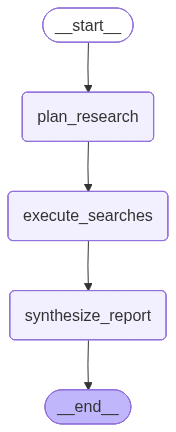

In [18]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(knowledge_cache_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 11. Agent Wrapper for Evaluation

In [ ]:
async def knowledge_cache_agent_async(inputs: dict) -> dict:
    """
    Async version of the Knowledge Cache research agent.
    Use this version when calling from Jupyter notebooks.
    """
    # Reset knowledge base for fresh session
    global knowledge_base
    knowledge_base = KnowledgeBase()

    question = inputs.get("question", "")

    result = await knowledge_cache_graph.ainvoke(
        {"question": question},
        config={"recursion_limit": 50}
    )

    return {
        "output": result.get("final_report", ""),
        "source_urls": list(set(result.get("source_urls", []))),
        "cache_decisions": result.get("cache_decisions", []),
        "cache_stats": knowledge_base.stats.copy()
    }


def knowledge_cache_agent(inputs: dict) -> dict:
    """
    Sync wrapper function for Knowledge Cache research agent.

    Compatible with evaluation harness.
    """
    question = inputs.get("question", "")

    async def _execute():
        global knowledge_base
        knowledge_base = KnowledgeBase()

        return await knowledge_cache_graph.ainvoke(
            {"question": question},
            config={"recursion_limit": 50}
        )

    try:
        loop = asyncio.get_running_loop()
        import concurrent.futures
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(asyncio.run, _execute())
            result = future.result()
    except RuntimeError:
        result = asyncio.run(_execute())

    return {
        "output": result.get("final_report", ""),
        "source_urls": list(set(result.get("source_urls", []))),
        "cache_decisions": result.get("cache_decisions", []),
        "cache_stats": knowledge_base.stats.copy()
    }

## 12. Manual Test

Run this cell to verify the agent works correctly with a simple test question.

In [ ]:
# Test with a question that naturally involves overlapping queries
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing Knowledge Cache Agent with question:\n{test_question}\n")
print("Running cascaded cache research (this may take several minutes)...\n")

try:
    result = await knowledge_cache_agent_async({"question": test_question})

    print("\n" + "=" * 80)
    print("FINAL REPORT")
    print("=" * 80)
    print(result["output"][:3000] + "..." if len(result["output"]) > 3000 else result["output"])

    print("\n" + "=" * 80)
    print("CACHE PERFORMANCE")
    print("=" * 80)
    stats = result.get("cache_stats", {})
    print(f"Total queries processed: {stats.get('total_queries', 0)}")
    print(f"Web searches avoided: {stats.get('web_searches_avoided', 0)}")
    print(f"Web searches executed: {stats.get('web_searches_executed', 0)}")
    hit_rate = (stats.get('web_searches_avoided', 0) / max(stats.get('total_queries', 1), 1)) * 100
    print(f"Cache hit rate: {hit_rate:.1f}%")

    print("\n" + "=" * 80)
    print("CACHE DECISION TRACE")
    print("=" * 80)
    for i, decision in enumerate(result.get("cache_decisions", [])[:10], 1):
        print(f"{i}. [{decision.get('layer_reached')}] {decision.get('action_taken')} - {decision.get('reasoning', '')[:60]}...")

    print("\nAgent test PASSED")
except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()
    raise

## 13. Evaluation Harness Integration

Once the manual test passes, uncomment and run the cells below for full evaluation.

In [ ]:
# Import evaluation harness and metrics
import sys
sys.path.insert(0, "..")
from evaluation import (
    ExperimentHarness,
    fact_recall,
    citation_precision,
    coherence_judge,
    depth_judge,
    relevance_judge,
    minimum_sources_check
)

# Initialize harness with the golden test dataset
harness = ExperimentHarness(
    dataset_path="../data/deep_research_agent_test_dataset.yaml",
    langsmith_dataset_name="deep-research-golden-v2"
)

print("Evaluation harness initialized successfully!")
print(f"Dataset: {harness.dataset_path}")
print(f"LangSmith dataset name: {harness.langsmith_dataset_name}")

In [ ]:
# Full Evaluation on All 20 Questions
# EXPENSIVE - Only uncomment when ready for full evaluation
# Uncomment to run:

# evaluators = [
#     fact_recall,
#     citation_precision,
#     minimum_sources_check,
#     coherence_judge,
#     depth_judge,
#     relevance_judge,
# ]
#
# print("Starting FULL evaluation on all 20 questions...")
# print("Knowledge Cache Agent - this will take 1-2 hours.")
# print("=" * 80 + "\n")
#
# results = harness.run_evaluation(
#     agent_fn=knowledge_cache_agent,
#     evaluators=evaluators,
#     experiment_name="knowledge_cache_v1",
#     monte_carlo_runs=1,
#     max_concurrency=2,
#     description="Knowledge Cache paradigm evaluation on all difficulty tiers"
# )
#
# print("\n" + "=" * 80)
# print("FULL EVALUATION RESULTS")
# print("=" * 80)
# print(f"Experiment: {results.experiment_name}")
# print(f"Questions evaluated: {results.num_questions}")
#
# print(f"\n{'Metric':<30} {'Mean':<10}")
# print("-" * 40)
# for metric_name in sorted(results.metrics.keys()):
#     if not metric_name.endswith('_std'):
#         value = results.metrics.get(metric_name, 0)
#         print(f"{metric_name:<30} {value:<10.3f}")

print("Full evaluation cell ready. Uncomment to run when ready.")

## Architecture Benefits

### Why Cascading Cache Works

1. **Layer 1 (Deterministic)**: Perfect precision, negligible cost
   - Catches exact query repetitions
   - URL deduplication prevents re-fetching
   - O(1) hash table lookups

2. **Layer 2 (Semantic)**: High recall, low cost
   - Vector similarity finds paraphrased queries
   - Multi-signal confidence prevents false positives
   - Adjustable thresholds for query specificity

3. **Layer 3 (LLM Judgment)**: Handles ambiguity
   - Only invoked for medium-confidence cases
   - Gap analysis enables targeted search
   - Human-like reasoning about sufficiency

### Expected Benefits

- **Latency Reduction**: Cache hits bypass network latency (500ms-3s per search)
- **Cost Savings**: Each avoided API call saves ~$0.01-0.05
- **Consistency**: Same data used throughout session
- **Token Efficiency**: Reduced redundant content in context